In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from scipy.interpolate import griddata

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

grid_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
avg_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m.nc')

lat_obs = -70.22526
lon_obs = 71.39695

In [3]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:56604 Dashboard: http://127.0.0.1:42285/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [2]:
grd = xr.open_dataset(grid_path)
avg = xr.open_dataset(avg_path)
shelves_path = os.path.join(data_dir,'analysis','interim','shelves2.npy')
shelves = np.load(shelves_path).item()

In [25]:
m_am06 = avg.m.isel(eta_rho=0,xi_rho=0)

In [36]:
mask = (grd.lon_rho < (lon_obs + 1)) & (grd.lon_rho > (lon_obs - 1)) & (grd.lat_rho < (lat_obs + 1)) & (grd.lat_rho > (lat_obs - 1))
lats = grd.lat_rho.values[mask].flatten()
lons = grd.lon_rho.values[mask].flatten()
for i,time in enumerate(avg.ocean_time):
    data = avg.sel(ocean_time=time).m.values[mask].flatten()
    
    m_am06[i] = griddata((lats,lons),data,(lat_obs,lon_obs))*365*24*3600

In [41]:
m_amery = avg.m.where(shelves["Amery"]['mask']).mean(['xi_rho','eta_rho'])*365*24*3600

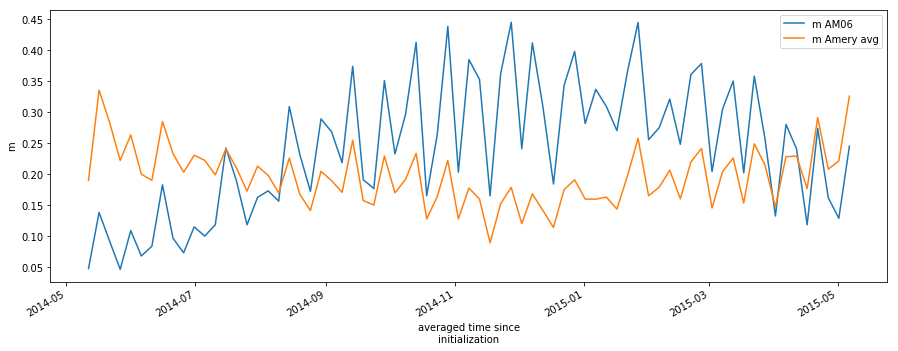

In [55]:
plt.close()
fig,ax = plt.subplots(figsize=(15,5))
m_am06.plot(ax=ax)
m_amery.plot(ax=ax)
plt.legend(['m AM06','m Amery avg'])
plt.show()

In [52]:
out = xr.Dataset({'m AM06':m_am06,'m Amery':m_amery})
out_path = os.path.join(data_dir,'analysis','processed','avg_m_AM06_Amery.nc')
out.to_netcdf(out_path)